In [ ]:
import pandas as pd

df  =  pd.read_csv('data/agg.txt', sep = '\t')
df.head()


,group,study.quarter,actor,target,number.wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [ ]:
df  =  df.rename(columns = {
    'group': 'group',
    'study.quarter': 'quarter',
    'actor': 'actor',
    'target': 'target',
    'number.wins': 'wins'
})

df.head()

,group,quarter,actor,target,wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [ ]:
df['group']  =  df['group'].str.replace('G', '').astype(int)
df['quarter']  =  df['quarter'].astype(int)


In [7]:
print(df['group'].value_counts())
print(df['quarter'].value_counts())


group
2    483
1    477
Name: count, dtype: int64
quarter
4    273
1    235
3    228
2    224
Name: count, dtype: int64


In [ ]:
groups  =  sorted(df['group'].unique())
quarters  =  sorted(df['quarter'].unique())

groups, quarters

([np.int64(1), np.int64(2)],
 [np.int64(1), np.int64(2), np.int64(3), np.int64(4)])

In [ ]:
import numpy as np

adj_mats  =  {}   # dictionary to store adjacency matrices
nodes_by_group  =  {}  # to store full node lists per group

In [ ]:
for g in groups:
    group_df  =  df[df['group'] == g]
    
    # get all individuals that ever appear in this group
    nodes  =  sorted(set(group_df['actor']).union(group_df['target']))
    nodes_by_group[g]  =  nodes
    
    for q in quarters:
        sub  =  group_df[group_df['quarter'] == q]
        
        if len(sub) == 0:
            continue
        
        # Create adjacency matrix using pivot
        A  =  sub.pivot_table(
            index = 'actor', 
            columns = 'target',
            values = 'wins',
            aggfunc = 'sum',
            fill_value = 0
        )
        
        # Ensure full node list is represented (rows and columns)
        A  =  A.reindex(index = nodes, columns = nodes, fill_value = 0)
        
        # Store it
        adj_mats[(g, q)]  =  A

In [11]:
adj_mats[(1, 1)].head()

target,bbb,bgn,bgr,bng,brn,brr,gbb,ggg,gpn,grb,...,grr,nbg,nrb,oon,rbr,rgn,rnb,rng,rrr,ryn
actor,,,,,,,,,,,,,,,,,,,,,
bbb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
bgn,0,0,0,2,0,0,0,4,0,0,...,1,0,3,2,0,0,1,0,0,0
bgr,0,0,0,0,0,4,0,1,0,0,...,1,0,0,0,0,0,0,2,0,0
bng,0,0,0,0,0,3,0,0,0,0,...,0,0,2,0,0,0,1,0,0,0
brn,0,1,1,1,0,0,1,1,0,1,...,0,2,0,1,0,1,0,0,1,0


In [ ]:
for g in groups:
    for q in quarters:
        if (g,q) in adj_mats:
            A  =  adj_mats[(g,q)]
            print(f"Group {g}, Quarter {q}: {A.shape[0]} nodes")


Group 1, Quarter 1: 21 nodes
Group 1, Quarter 2: 21 nodes
Group 1, Quarter 3: 21 nodes
Group 1, Quarter 4: 21 nodes
Group 2, Quarter 1: 19 nodes
Group 2, Quarter 2: 19 nodes
Group 2, Quarter 3: 19 nodes
Group 2, Quarter 4: 19 nodes


In [ ]:
def violation_cost(order, A):
    """
    order: list of nodes, index 0  =  highest rank
    A: adjacency matrix (pandas DataFrame)
    """
    rank  =  {node: i for i, node in enumerate(order)}
    V  =  0
    
    for i in order:
        for j in order:
            w  =  A.loc[i, j]
            if w > 0 and rank[i] > rank[j]:
                V + =  w
    return V

In [ ]:
def try_swap(order, i, j):
    new_order  =  order.copy()
    new_order[i], new_order[j]  =  new_order[j], new_order[i]
    return new_order


In [ ]:
import random

def mvr(A, max_iter = 300):
    """
    A: adjacency matrix
    max_iter: number of random restarts
    Returns: (best_order, best_cost)
    """
    
    nodes  =  list(A.index)
    best_order  =  None
    best_cost  =  float('inf')

    for _ in range(max_iter):

        # Start with a random ordering
        order  =  nodes.copy()
        random.shuffle(order)
        
        current_cost  =  violation_cost(order, A)
        improved  =  True

        # Hill-climbing until convergence
        while improved:
            improved  =  False
            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    new_order  =  try_swap(order, i, j)
                    new_cost  =  violation_cost(new_order, A)
                    
                    if new_cost < current_cost:
                        order  =  new_order
                        current_cost  =  new_cost
                        improved  =  True
        
        # After local minimum is reached, update global best
        if current_cost < best_cost:
            best_cost  =  current_cost
            best_order  =  order.copy()

    return best_order, best_cost


In [ ]:
A  =  adj_mats[(1, 1)]  # Group 1, Quarter 1
order, cost  =  mvr(A, max_iter = 200)

print("Order:", order)
print("Violations:", cost)


Order: ['ryn', 'brn', 'gbb', 'bgn', 'nbg', 'bgr', 'rrr', 'oon', 'ggg', 'bng', 'nrb', 'grg', 'grr', 'rnb', 'brr', 'rng', 'grb', 'bbb', 'rbr', 'rgn', 'gpn']
Violations: 7


In [ ]:
results_mvr  =  {}   # key: (group, quarter)

In [ ]:
for g in groups:
    for q in quarters:
        key  =  (g, q)
        if key not in adj_mats:
            continue
        
        print(f"Running MVR → Group {g}, Quarter {q}")
        
        A  =  adj_mats[key]
        
        # Run MVR
        order, V  =  mvr(A, max_iter = 300)
        
        # Store results
        results_mvr[key]  =  {
            'order': order,
            'violations': V,
            'A': A
        }


Running MVR → Group 1, Quarter 1
Running MVR → Group 1, Quarter 2
Running MVR → Group 1, Quarter 3
Running MVR → Group 1, Quarter 4
Running MVR → Group 2, Quarter 1
Running MVR → Group 2, Quarter 2
Running MVR → Group 2, Quarter 3
Running MVR → Group 2, Quarter 4


In [19]:
results_mvr[(1,1)]

{'order': ['ryn',
  'brn',
  'gbb',
  'nbg',
  'bgn',
  'bgr',
  'ggg',
  'bng',
  'nrb',
  'rnb',
  'rrr',
  'oon',
  'grg',
  'grr',
  'brr',
  'grb',
  'rng',
  'bbb',
  'rbr',
  'rgn',
  'gpn'],
 'violations': np.int64(7),
 'A': target  bbb  bgn  bgr  bng  brn  brr  gbb  ggg  gpn  grb  ...  grr  nbg  nrb  \
 actor                                                     ...                  
 bbb       0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
 bgn       0    0    0    2    0    0    0    4    0    0  ...    1    0    3   
 bgr       0    0    0    0    0    4    0    1    0    0  ...    1    0    0   
 bng       0    0    0    0    0    3    0    0    0    0  ...    0    0    2   
 brn       0    1    1    1    0    0    1    1    0    1  ...    0    2    0   
 brr       0    0    0    0    0    0    0    0    2    4  ...    0    0    0   
 gbb       2    1    1    0    0    4    0    4    1    3  ...    1    1    2   
 ggg       0    0    0    3    0    1  

In [20]:
results_mvr[(1,1)]['order']

['ryn',
 'brn',
 'gbb',
 'nbg',
 'bgn',
 'bgr',
 'ggg',
 'bng',
 'nrb',
 'rnb',
 'rrr',
 'oon',
 'grg',
 'grr',
 'brr',
 'grb',
 'rng',
 'bbb',
 'rbr',
 'rgn',
 'gpn']

In [21]:
results_mvr[(1,1)]['violations']


np.int64(7)

In [ ]:
rows  =  []

for (g, q), data in results_mvr.items():
    order  =  data['order']
    for rank_position, node in enumerate(order):
        rows.append({
            'group': g,
            'quarter': q,
            'individual': node,
            'rank': rank_position,      # 0  =  highest rank (most dominant)
            'violations': data['violations']
        })

df_mvr  =  pd.DataFrame(rows)
df_mvr.head()


,group,quarter,individual,rank,violations
0,1,1,ryn,0,7
1,1,1,brn,1,7
2,1,1,gbb,2,7
3,1,1,nbg,3,7
4,1,1,bgn,4,7


In [ ]:
df_mvr.groupby(['group','quarter'])['violations'].first()


group  quarter
1      1           7
       2           9
       3          23
       4          13
2      1          53
       2           5
       3          14
       4          21
Name: violations, dtype: int64

In [ ]:
df_mvr[df_mvr['quarter'] == 1].sort_values(['group','rank']).head(20)

,group,quarter,individual,rank,violations
0,1,1,ryn,0,7
1,1,1,brn,1,7
2,1,1,gbb,2,7
3,1,1,nbg,3,7
4,1,1,bgn,4,7
5,1,1,bgr,5,7
6,1,1,ggg,6,7
7,1,1,bng,7,7
8,1,1,nrb,8,7
9,1,1,rnb,9,7


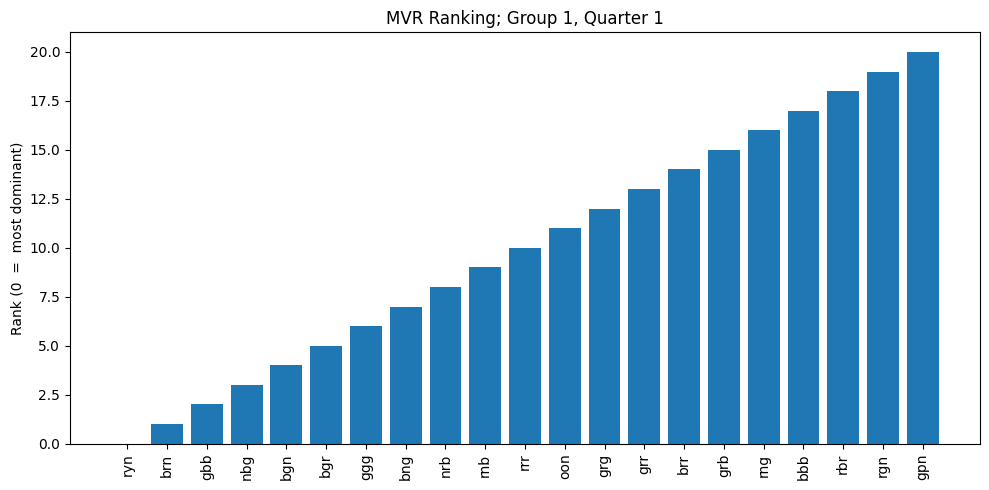

In [33]:
import matplotlib.pyplot as plt

def plot_mvr_barplot(group, quarter):
    data  =  results_mvr[(group, quarter)]
    order  =  data['order']
    
    plt.figure(figsize = (10, 5))
    plt.bar(range(len(order)), range(len(order)), tick_label = order)
    plt.xticks(rotation = 90)
    plt.ylabel("Rank (0  =  most dominant)")
    plt.title(f"MVR Ranking; Group {group}, Quarter {quarter}")
    plt.tight_layout()
    plt.show()

# Example:
plot_mvr_barplot(1, 1)

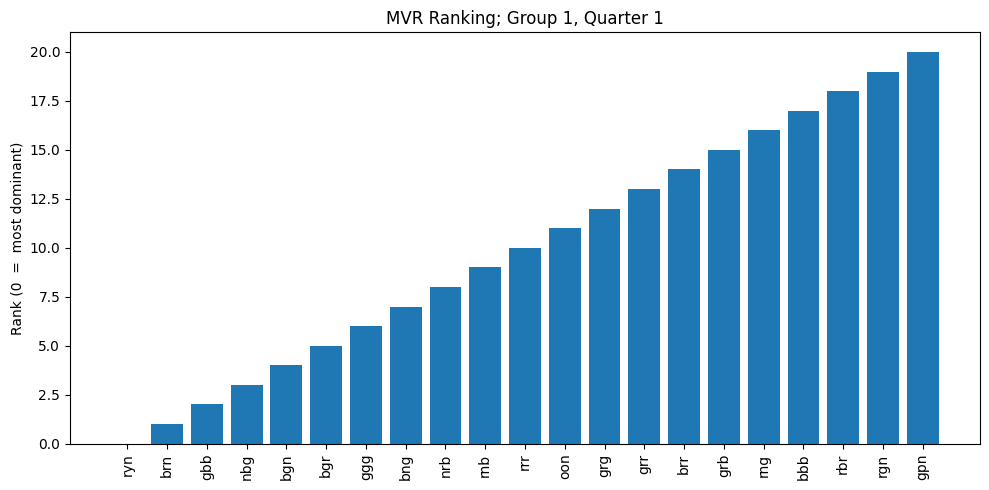

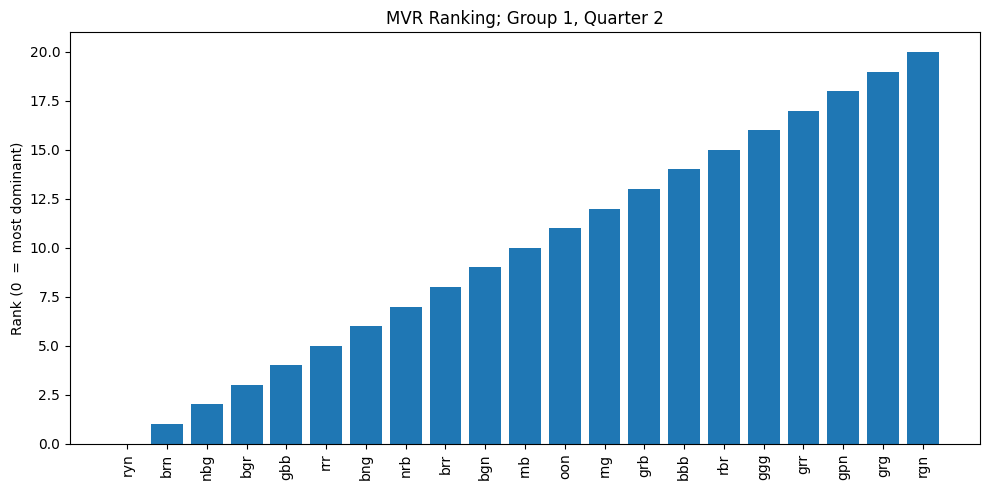

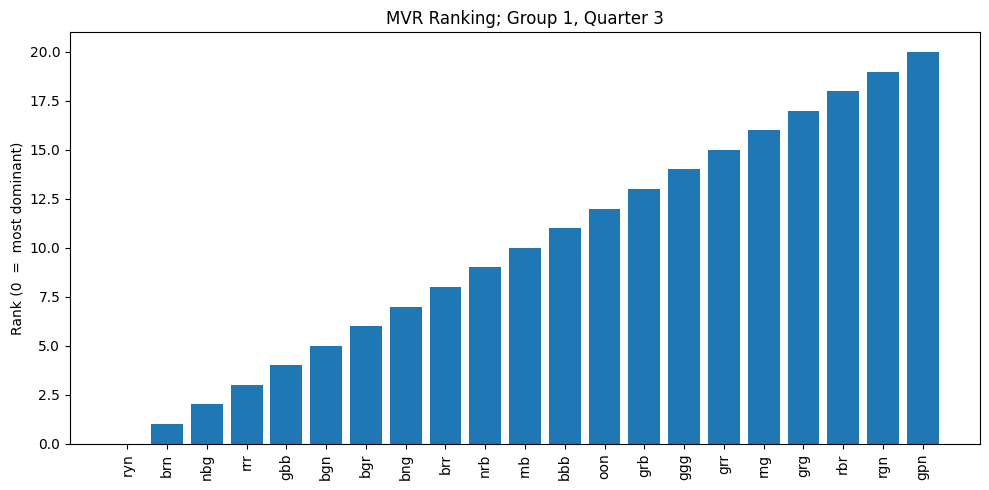

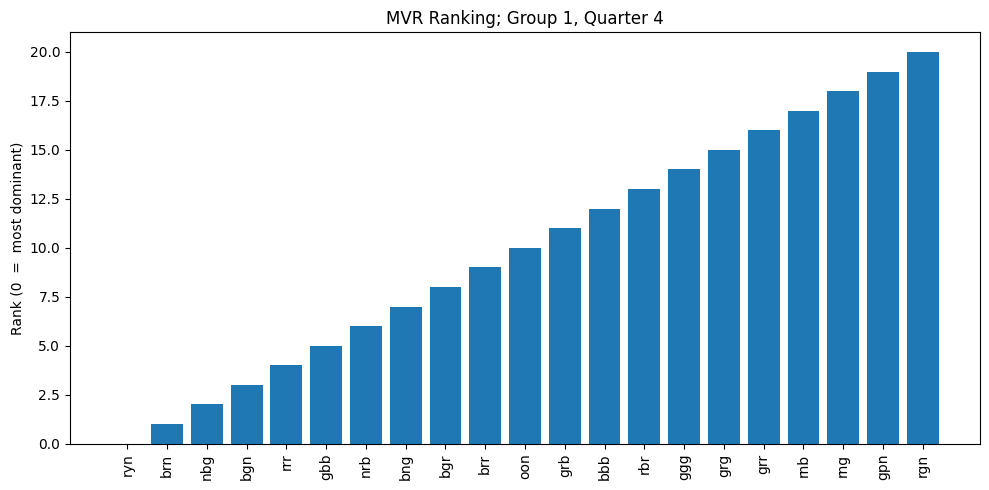

In [34]:
for q in [1,2,3,4]:
    plot_mvr_barplot(1, q)

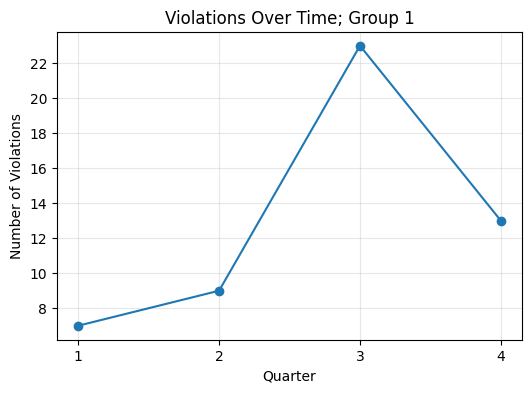

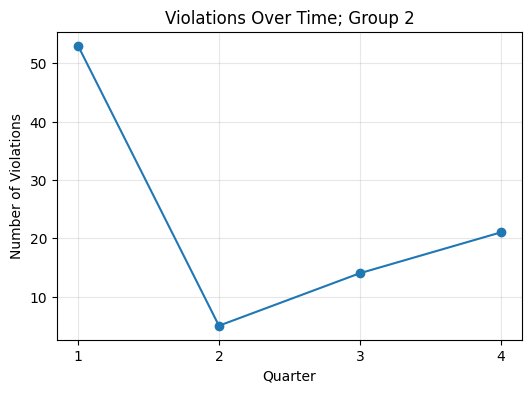

In [37]:
def plot_violation_trend(group):
    vals  =  []
    for q in [1,2,3,4]:
        V  =  results_mvr[(group,q)]['violations']
        vals.append(V)
    
    plt.figure(figsize = (6,4))
    plt.plot([1,2,3,4], vals, marker = 'o')
    plt.xticks([1,2,3,4])
    plt.xlabel("Quarter")
    plt.ylabel("Number of Violations")
    plt.title(f"Violations Over Time; Group {group}")
    plt.grid(True, alpha = 0.3)
    plt.show()

plot_violation_trend(1)
plot_violation_trend(2)


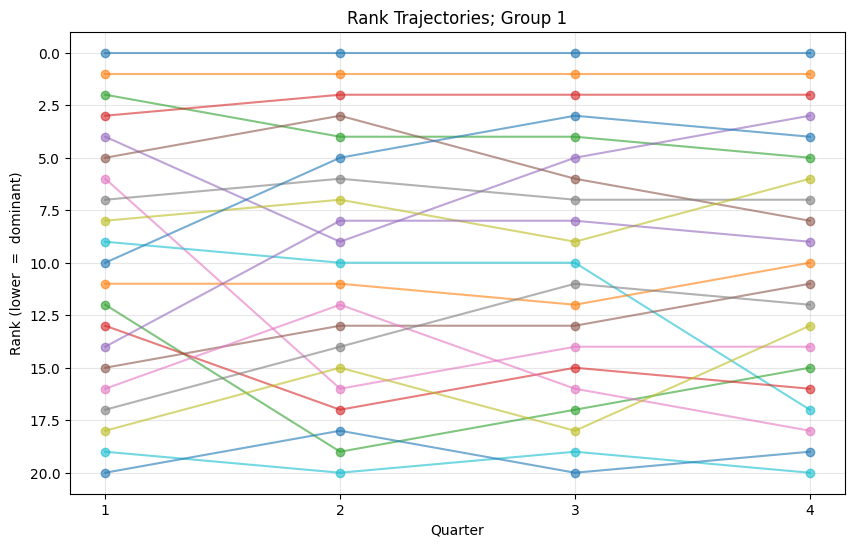

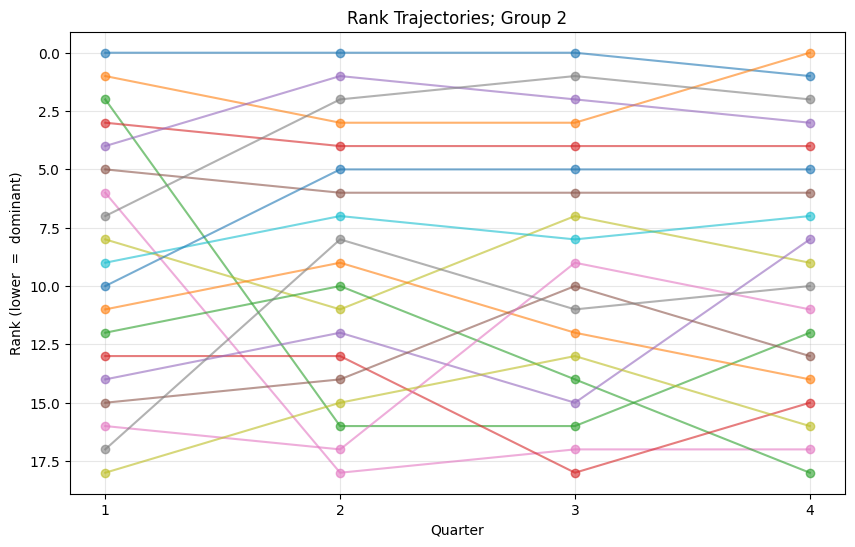

In [36]:
def plot_rank_trajectories(group):
    tmp  =  df_mvr[df_mvr['group'] == group]
    
    plt.figure(figsize = (10,6))
    
    for bird in tmp['individual'].unique():
        sub  =  tmp[tmp['individual'] == bird].sort_values('quarter')
        plt.plot(sub['quarter'], sub['rank'], marker = 'o', alpha = 0.6)
    
    plt.gca().invert_yaxis()   # rank 0 at top
    plt.xticks([1,2,3,4])
    plt.xlabel("Quarter")
    plt.ylabel("Rank (lower  =  dominant)")
    plt.title(f"Rank Trajectories; Group {group}")
    plt.grid(True, alpha = 0.3)
    plt.show()

plot_rank_trajectories(1)
plot_rank_trajectories(2)


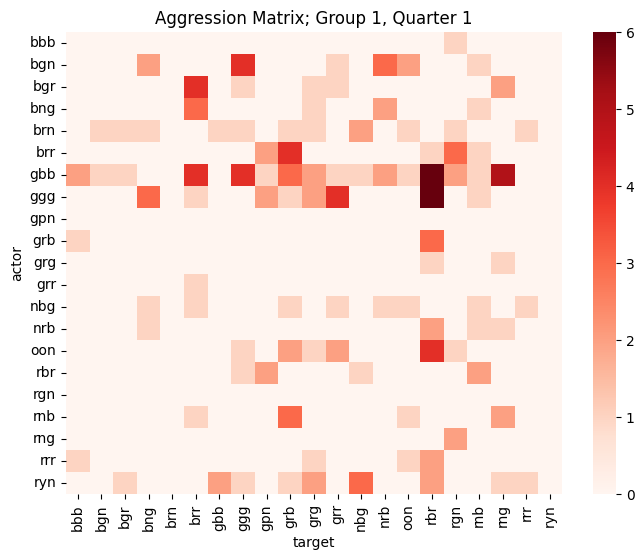

In [38]:
def plot_heatmap(group, quarter):
    import seaborn as sns  # if allowed; otherwise matplotlib imshow is fine
    
    A  =  results_mvr[(group,quarter)]['A']
    
    plt.figure(figsize = (8,6))
    sns.heatmap(A, cmap = "Reds")
    plt.title(f"Aggression Matrix; Group {group}, Quarter {quarter}")
    plt.show()

# Example:
plot_heatmap(1, 1)


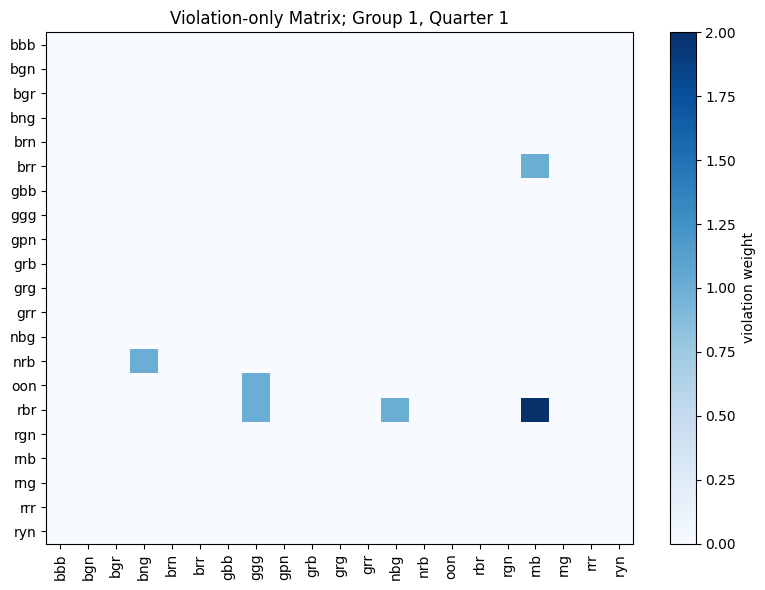

In [39]:
def plot_violation_matrix(group, quarter):
    data  =  results_mvr[(group,quarter)]
    order  =  data['order']
    A  =  data['A']
    
    rank  =  {node: i for i, node in enumerate(order)}
    
    Vmat  =  A.copy()
    for i in A.index:
        for j in A.columns:
            if not (rank[i] > rank[j]):  # if not a violation
                Vmat.loc[i,j]  =  0
    
    plt.figure(figsize = (8,6))
    plt.imshow(Vmat.values, cmap = 'Blues', aspect = 'auto')
    plt.colorbar(label = 'violation weight')
    plt.xticks(range(len(Vmat.columns)), Vmat.columns, rotation = 90)
    plt.yticks(range(len(Vmat.index)), Vmat.index)
    plt.title(f"Violation-only Matrix; Group {group}, Quarter {quarter}")
    plt.tight_layout()
    plt.show()

plot_violation_matrix(1,1)